# Exercise 5, Machine Learning 2022

The following lab-session is adapted from those of Sections 5.3 and 6.3 in Introduction to Statistical Learning with R.

### The Auto dataset
We use the `Auto` dataset that was used as an example throughout Chapter 3 on linear regression. Here, we treat the variable `mpg` (gas miles in miles per gallon) as the response and `horsepower` as the single predictor.

The data has 392 observations on the following 9 variables.

`mpg` miles per gallon

`cylinders` Number of cylinders between 4 and 8 displacementEngine displacement (cu. inches) 

`horsepower` Engine horsepower

`weight` Vehicle weight (lbs.)

`acceleration` Time to accelerate from 0 to 60 mph (sec.)

`year` Model year (modulo 100)

`origin` Origin of car (1. American, 2. European, 3. Japanese)

`name` Vehicle name

In [1]:
# Import relevant packages
import numpy as np
from pandas import read_csv, DataFrame
from math import log, sqrt
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf 

import random

In [2]:
# Load data from csv; change the directory as you need!
auto = read_csv("Auto.csv")
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


*It is recommended that you set a random seed, so that any results based on randomness are recreated whenever you run the notebook.*

In [3]:
## Set seed!
random.seed(30)

## The validation set approach

### TO DO

- Split the set of observations into two halves by selecting a random subset of 196 obervations out of the original 392 observations. We refer to these observations as the *training set* and the remaining observations as the *validation set*.    
- **TIPS**: _For creating the random split, you can use `random.sample(seq, n)` to select `n` numbers without replacement from the sequence `seq`. (There is also a built-in function `train_test_split` that can split your data, but here you split it yourself so that you understand in detail how to achieve the datasets)._

In [4]:
def randomize_split(n, n_samples):
    
    train_idx = random.sample([x for x in range(n)], n_samples)

    val_idx = [x for x in range(n) if x not in train_idx]
    
    return train_idx, val_idx

In [5]:
train_idx, val_idx = randomize_split(392, 196)

In [6]:
train = auto.iloc[train_idx, :]
X_train = train["horsepower"]
X_train = sm.add_constant(X_train) #add column of 1s in the design matrix bc statsmodels doesn't automatically do this
y_train = train["mpg"]

val = auto.iloc[val_idx, :]
X_val = val["horsepower"]
X_val = sm.add_constant(X_val)
y_val = val["mpg"]

In [7]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

(196, 2)
(196,)
(196, 2)
(196,)


### Print design matrix to see what it looks like

In [8]:
print(X_train)

     const  horsepower
276    1.0          71
148    1.0          93
312    1.0          88
15     1.0          95
318    1.0          92
..     ...         ...
77     1.0          87
355    1.0          76
300    1.0          70
89     1.0         198
38     1.0         175

[196 rows x 2 columns]


### TO DO
- Fit a linear regression on the training set: `mpg`$= \beta_0 + \beta_1$ `horsepower` $+\epsilon$.

In [9]:
lm1 = sm.OLS(y_train, X_train).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     296.7
Date:                Tue, 10 Sep 2024   Prob (F-statistic):           5.93e-41
Time:                        11:01:13   Log-Likelihood:                -593.79
No. Observations:                 196   AIC:                             1192.
Df Residuals:                     194   BIC:                             1198.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9738      1.024     39.029      0.000      37.954      41.994
horsepower    -0.1575      0.009    -17.225      0.000      -0.175      -0.139
==============================================================================
Omnibus:                       14.826   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.035
Skew:                           0.632   Prob(JB):                     0.000330
Kurtosis:                       3.605   Cond. No.                         319.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Compute the MSE on the 196 observations that are the validation set.

### Get predictions on the validation set and calculate the MSE

In [12]:
lm1.predict(X_val)

2      16.356248
4      17.930753
6       5.334711
7       6.121964
8       4.547459
         ...    
385    26.747983
386    25.803280
388    31.786399
389    26.747983
390    27.535235
Length: 196, dtype: float64

In [10]:
pred_val =  lm1.get_prediction(X_val).summary_frame()["mean"]

statsmodels.tools.eval_measures.mse(x1, x2, axis=0)

In [13]:
mse_val = sm.tools.eval_measures.mse(y_val, pred_val)
mse_val

22.842577966182787

### TO DO 
- Now estimate also the MSE for the quadradic and cubic regressions.
The ISLwR book found an estimated test MSE of (23.27, 18.27, and 18.79) for the three regression models. 

### Function for getting the MSE of a given statsmodels model

In [14]:
def get_mse(model, X, y):
    
    preds =  model.get_prediction(X).summary_frame()["mean"]
    mse = sm.tools.eval_measures.mse(y, preds)
    
    return mse

### Fit quadratic and cubic regressions using statsmodels

### sm.OLS method

We need the polynomial features in the design matrix (X) so to do that I will use the PolynomialFeatures class from sklearn to get the design matrices in very few lines of code

In [16]:
from sklearn.preprocessing import PolynomialFeatures

In [18]:
X = train["horsepower"].to_numpy()
polynomial_features= PolynomialFeatures(degree=2)
X_train_2deg = polynomial_features.fit_transform(X.reshape(-1,1)) #if you don't reshape X as such if it's a single feature
                                                                #vector you will get an error telling you to do so

### Check out what the design matrix for the quadratic model looks like

In [19]:
X_train_2deg.shape

(196, 3)

In [20]:
X_train_2deg

array([[1.0000e+00, 7.1000e+01, 5.0410e+03],
       [1.0000e+00, 9.3000e+01, 8.6490e+03],
       [1.0000e+00, 8.8000e+01, 7.7440e+03],
       [1.0000e+00, 9.5000e+01, 9.0250e+03],
       [1.0000e+00, 9.2000e+01, 8.4640e+03],
       [1.0000e+00, 8.4000e+01, 7.0560e+03],
       [1.0000e+00, 8.8000e+01, 7.7440e+03],
       [1.0000e+00, 1.0000e+02, 1.0000e+04],
       [1.0000e+00, 9.0000e+01, 8.1000e+03],
       [1.0000e+00, 7.5000e+01, 5.6250e+03],
       [1.0000e+00, 9.0000e+01, 8.1000e+03],
       [1.0000e+00, 6.7000e+01, 4.4890e+03],
       [1.0000e+00, 1.6000e+02, 2.5600e+04],
       [1.0000e+00, 1.8000e+02, 3.2400e+04],
       [1.0000e+00, 8.3000e+01, 6.8890e+03],
       [1.0000e+00, 1.5000e+02, 2.2500e+04],
       [1.0000e+00, 7.5000e+01, 5.6250e+03],
       [1.0000e+00, 9.5000e+01, 9.0250e+03],
       [1.0000e+00, 2.2500e+02, 5.0625e+04],
       [1.0000e+00, 1.6500e+02, 2.7225e+04],
       [1.0000e+00, 9.7000e+01, 9.4090e+03],
       [1.0000e+00, 9.0000e+01, 8.1000e+03],
       [1.

### Fit the actual quadratic model and calculate the MSE

**Then do the same for the cubic model**

In [21]:
sm_quad = sm.OLS(y_train, X_train_2deg).fit()
sm_quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     222.6
Date:                Tue, 10 Sep 2024   Prob (F-statistic):           7.60e-51
Time:                        11:16:40   Log-Likelihood:                -567.53
No. Observations:                 196   AIC:                             1141.
Df Residuals:                     193   BIC:                             1151.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.1407      2.524     23.032      0.000      53.162      63.120
x1            -0.4861      0.043    -11.194      0.000      -0.572      -0.400
x2             0.0013      0.000      7.701      0.000       0.001       0.002
==============================================================================
Omnibus:                       17.593   Durbin-Watson:                   2.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.470
Skew:                           0.417   Prob(JB):                     1.99e-08
Kurtosis:                       4.910   Cond. No.                     1.29e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
X_val_2deg = polynomial_features.fit_transform((val["horsepower"]).to_numpy().reshape(-1,1))
mse_quad = get_mse(sm_quad, X_val_2deg, y_val)
print(mse_quad)

18.852745430127555


### Do the same for the cubic model

In [23]:
poly3 = PolynomialFeatures(degree=3)

X_train_3deg = poly3.fit_transform((train["horsepower"]).to_numpy().reshape(-1,1))
X_val_3deg = poly3.fit_transform((val["horsepower"]).to_numpy().reshape(-1,1))

sm_cube = sm.OLS(y_train, X_train_3deg).fit()

mse_cube = get_mse(sm_cube, X_val_3deg, y_val)

print(mse_cube)

19.075536759324212


### formula api (smf.ols) method

**You can also achieve the same with the formula api**  
**Example with the cubic model**

In [24]:
lm_cube = smf.ols("mpg ~ 1+ horsepower + I(horsepower**2) + I(horsepower**3)", train).fit()
pred_val_cube =  lm_cube.get_prediction(val).summary_frame()["mean"]
mse_val_cube = sm.tools.eval_measures.mse(y_val, pred_val_cube)
mse_val_cube

19.075536759324212

As you can see we get the same result

### TO DO
- Set another seed and create a different split of your data - do you get different results? Why?

In [25]:
random.seed(22)

train_idx2, val_idx2 = randomize_split(392, 196)

train2 = auto.iloc[train_idx2, :]
val2 = auto.iloc[val_idx2, :]
true_val2 = val2["mpg"]
val2 = val2["horsepower"]

lm12 = smf.ols("mpg ~ 1+ horsepower", train2).fit()
mse_val2 = get_mse(lm12, val2, true_val2)
print(mse_val2)

lm_quad2 = smf.ols("mpg ~ 1+ horsepower + I(horsepower**2)", train2).fit()
mse_val_quad2 = get_mse(lm_quad2, val2, true_val2)
print(mse_val_quad2)

lm_cube2 = smf.ols("mpg ~ 1+ horsepower + I(horsepower**2) + I(horsepower**3)", train2).fit()
mse_val_cube2 = get_mse(lm_cube2, val2, true_val2)
print(mse_val_cube2)

24.596948801393975
20.14035992764117
20.77892944825929


Yes, we do get different results because we are using different data for the training and testing

### TO DO
- Which model would you choose based on the estimated MSE?

I would choose the 2nd model (the quadratic one), because it has the lowest MSE, while still being a fairly simple model. 

### TO DO
- If you instead train the models on the entire data and perform model selection via F-tests or AIC, would you choose differently?

In [26]:
lm1_3 = smf.ols("mpg ~ 1+ horsepower", auto).fit()
lm_quad_3 = smf.ols("mpg ~ 1+ horsepower + I(horsepower**2)", auto).fit()
lm_cube_3 = smf.ols("mpg ~ 1+ horsepower + I(horsepower**2) + I(horsepower**3)", auto).fit()

In [27]:
print(lm1_3.aic)
print(lm_quad_3.aic)
print(lm_cube_3.aic)

2361.3236578374017
2272.353522359692
2273.5312967115547


Based on AIC only, I would choose the second model because the general rule of thumb is the lower AIC the better. However this metric is known to favoritize simpler models, and using only using AIC to choose may result in underfitting.

## Leave-one-out cross-validation

### TO DO
- Implement leave-one-out cross-validation and use it to estimate the MSE for the three regression models above.

**NOTE: Here I will use the class from sklearn, but you can try to implement it from scratch yourself as an extra challenge if you're feeling brave :)**

In [28]:
from sklearn.model_selection import LeaveOneOut

In [29]:
loocv = LeaveOneOut()

### Function to format the polynomial formula for the formula api
I am doing this because we will need it later on and we can use it from now to make the code a lot nicer

In [30]:
def format_formula(d):
    
    f = "mpg ~ 1 + horsepower"
    
    if d == 1:
        return f
    else:
        for i in range(2, d+1):
            f += f" + I(horsepower**{i})"
   
    return f

Example:

In [31]:
format_formula(5)

'mpg ~ 1 + horsepower + I(horsepower**2) + I(horsepower**3) + I(horsepower**4) + I(horsepower**5)'

### Estimate MSE for the 3 models using LOOCV

In [32]:
metrics = [0] * 3

for i, (train_idx, val_idx) in enumerate(loocv.split(auto)):
    
    models = []
    
    train_loocv = auto.iloc[train_idx]
    val_loocv = auto.iloc[val_idx]
    true_vals = val_loocv["mpg"]
    val_loocv = val_loocv["horsepower"]
    
    for i in range(1,4):
        formula = format_formula(i)
        curr_lm = smf.ols(formula, train_loocv).fit()
        models.append(curr_lm)
    
    for i in range(3):

        curr_preds =  models[i].get_prediction(val_loocv).summary_frame()["mean"]
        metrics[i] += sm.tools.eval_measures.mse(true_vals, curr_preds)

for i in range(3):
    avg_mse = metrics[i] / (auto.shape[0])
    print(avg_mse)

24.231513517929244
19.248213124489315
19.334984064060897


## k-fold cross-validation

### TO DO
- Estimate the MSE now from k-fold cross-validation that you implement yourself. If you set k=10, then you get Figure 5.6 from the book, but you are welcome to choose another k. Make sure that you properly randomise observations into the k folds! One way is to first make a random permutation of row indices and then chop the re-ordered dataset into k (roughly) even parts.

The LOOCV estimate of the MSE can also be computed automatially with sklearn. In fact, sklearn provides a lot of functionality for cross-validation. However, our objective right now is to understand how the algorithms work, so that you learn to reflect on them and use the automatic functionality appropriately.

**NOTE: Here I have solved the exercise using the KFold class from sklearn. If you want, you can implement KFold yourself as an extra challenge :)**

In [33]:
from sklearn.model_selection import KFold

In [34]:
N_SPLITS = 10
kf = KFold(n_splits = N_SPLITS)

In [35]:
metrics = [0] * 3

auto_sh = auto.sample(frac=1).reset_index(drop=True)

for i, (train_idx, val_idx) in enumerate(kf.split(auto_sh)):
    
    models = []
    
    train_loocv = auto_sh.iloc[train_idx]
    val_loocv = auto_sh.iloc[val_idx]
    true_vals = val_loocv["mpg"]
    val_loocv = val_loocv["horsepower"]
    
    for i in range(1,4):
        formula = format_formula(i)
        curr_lm = smf.ols(formula, train_loocv).fit()
        models.append(curr_lm)
    
    for i in range(3):

        curr_preds =  models[i].get_prediction(val_loocv).summary_frame()["mean"]
        metrics[i] += sm.tools.eval_measures.mse(true_vals, curr_preds)
        
for i in range(3):
    avg_mse = metrics[i] / N_SPLITS
    print(avg_mse)

24.13816500046387
19.208462214531252
19.321071228938443


### TO DO
- Extend your code with a for-loop that iterates over increasing orders of the polynomial (1 to 10). Note that is possible to autogenerate a design matrix with all the terms of the polynomial with functions such as `sklearn.preprocessing.PolynomialFeatures` (It should also work for several features; a degree 2 polynomial in features x1 and x2 would need  $1+x_1+x_2+x_1x_2+x_1^2+x_2^2$, i.e. also the term $x_1x_2$.)

In [36]:
metrics = [0] * 10;

for i, (train_idx, val_idx) in enumerate(kf.split(auto_sh)):
    
    models = []
    
    train_loocv = auto_sh.iloc[train_idx]
    val_loocv = auto_sh.iloc[val_idx]
    true_vals = val_loocv["mpg"]
    val_loocv = val_loocv["horsepower"]
    
    for i in range(1, 11):
        
        formula = format_formula(i)
        curr_lm = smf.ols(formula, train_loocv).fit()
        models.append(curr_lm)
    
    for i in range(10):

        curr_preds =  models[i].get_prediction(val_loocv).summary_frame()["mean"]
        metrics[i] += sm.tools.eval_measures.mse(true_vals, curr_preds)

mses = []
for i in range(10):
    avg_mse = metrics[i] / 10
    mses.append(avg_mse)
    print(f"Avg MSE for poly d={i+1}: {avg_mse}")

Avg MSE for poly d=1: 24.13816500046387
Avg MSE for poly d=2: 19.208462214531252
Avg MSE for poly d=3: 19.321071228938443
Avg MSE for poly d=4: 19.40890138329201
Avg MSE for poly d=5: 19.051356330681738
Avg MSE for poly d=6: 19.084930326160457
Avg MSE for poly d=7: 19.09371772140657
Avg MSE for poly d=8: 23.15076714068223
Avg MSE for poly d=9: 23.228094568327943
Avg MSE for poly d=10: 51.32054181793635


## TO DO
- Plot the resulting MSE curve against the degree of the polynomial (this is the complexity or the flexibility).   
- Do you get the same conclusion as before regarding your choice of model?   
- Was it faster than LOOCV?

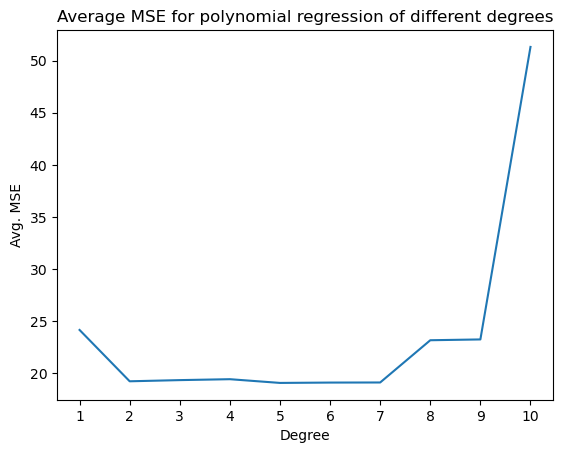

In [37]:
plt.plot(list(range(1,11)), mses)
plt.title("Average MSE for polynomial regression of different degrees")
plt.xlabel("Degree")
plt.ylabel("Avg. MSE")
plt.xticks(list(range(1,11)));

Based on the above plot, we would still choose the 2nd degree polynomial.
We can also notice that the KFold with 10 splits executed a lot faster than the LOOCV (Which makes sense, because LOOCV is esentially KFold with K=n, where n is the number of samples in your dataset. These numbers of folds correspond with how many times you execute the loop, so the more folds you have the slower the calculation will be).

## Shrinkage/Regularization

Now try the two shrinkage methods we saw on Thursday, ridge regression and lasso. To make things a bit more exciting, include in your models all variables available in the dataset, and perhaps a few polynomial terms for `horsepower` now that you know they are relevant. The `name` variable is evidently an identifyer and should not be used as a predictor in the model.

The Lasso estimates for coefficients $\beta$ in a linear regression model are found by minimising $RSS + \lambda\sum_{j=1}^p|\beta_j|$ rather than RSS. 

In Ridge regression, we estimate $\beta$ by minimising $RSS + \lambda\sum_{j=1}^p\beta_j^2$ rather than RSS. 

In both cases, we need to set the regularation parameter $\lambda$. **The parameter $\lambda$ is called `alpha` in the Python implementations**


The relevant method in the statsmodel library is `fit_regularized`, which you use in place of `fit` after instantiating an ols model. If `L1_wt=1`, the fit is the lasso (L1-penalty). Ridge regression (L2-penalty) is obtained by setting `L1_wt=0`.  The reason we need to set parameter `L1_wt` is that the method actually implements the more general 'elastic net' penalty, which is a convex combination of the Lasso penalty and the ridge regression penalty with weight `L1_wt`. The fitting method returns a `RegressionResults` object, from which you can extract `params` and `fittedvalues`, and it has a `predict` method just like the usual linear regression output from ols.

The sklearn libary has methods `Ridge` and `Lasso`. 

**Set aside a test set of about 25% of the data that you can use at the end to estimate the MSE of your final model. Use the remaining data to train the regularised regression models.**

### Ridge regression

### TO DO
- First, carry out a ridge regression where the regulation parameter $\lambda$ is fixed at 10. 

In [34]:
from sklearn.linear_model import Ridge

In [35]:
n_train = int(0.75 * (auto.shape[0]))
X_train = (auto.iloc[:n_train, 1:8]).to_numpy()
y_train = (auto.iloc[:n_train, 0]).to_numpy()
X_test = (auto.iloc[n_train:, 1:8]).to_numpy()
y_test = (auto.iloc[n_train:, 0]).to_numpy()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(294, 7)
(294,)
(98, 7)
(98,)


In [36]:
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)

Ridge(alpha=10)

In [37]:
preds_ridge = ridge_reg.predict(X_test)
mse_ridge = sm.tools.eval_measures.mse(y_test, preds_ridge)
print(mse_ridge)

35.86250991322604


In fact, $\lambda = 10$ is a rather arbitrary suggestion. We need to decide on a suitable value for the hyperparameter $\lambda$. This we can do using a dedicated validation set, or we could do it by cross-validation. We do the latter.

### TO DO
- Take a suitable range of $\lambda \in [0, \infty)$, for instance you can take a sequence $10^i, i=-2, \ldots, 5$. Using 5-fold cross-validation to estimate the MSE (call it `MSE_lambda`) for each $\lambda$, make a plot of how MSE changes with $\lambda$. Based on this plot, how would you choose $\lambda$? 

In [40]:
train_data = auto_sh.iloc[:n_train]

kf5 = KFold(n_splits=5)
metrics = [0] * 8;

for i, (train_idx, val_idx) in enumerate(kf5.split(train_data)):
    
    models = []
    
    train_loocv = train_data.iloc[train_idx]
    y_train_loocv = train_loocv.iloc[:,0]
    train_loocv = train_loocv.iloc[:,1:8]
    val_loocv = train_data.iloc[val_idx]
    true_vals = val_loocv.iloc[:, 0]
    val_loocv = val_loocv.iloc[:, 1:8]
    
    for i in range(-2, 6):
        
        curr_lambda = 10**i
        curr_ridge = Ridge(alpha = curr_lambda)
        curr_ridge.fit(train_loocv, y_train_loocv)
        models.append(curr_ridge)
    
    for i in range(8):

        curr_preds =  models[i].predict(val_loocv)
        metrics[i] += sm.tools.eval_measures.mse(true_vals, curr_preds)

mses = []
for i in range(8):
    avg_mse = metrics[i] / 5
    mses.append(avg_mse)
    print(f"Avg MSE (val data) for ridge regression with lambda={i-2}: {avg_mse}")

Avg MSE (val data) for ridge regression with lambda=-2: 8.253391197794063
Avg MSE (val data) for ridge regression with lambda=-1: 8.253161868693871
Avg MSE (val data) for ridge regression with lambda=0: 8.250969096054973
Avg MSE (val data) for ridge regression with lambda=1: 8.23674448389388
Avg MSE (val data) for ridge regression with lambda=2: 8.244015096355735
Avg MSE (val data) for ridge regression with lambda=3: 8.50045245146602
Avg MSE (val data) for ridge regression with lambda=4: 9.49629757132169
Avg MSE (val data) for ridge regression with lambda=5: 9.773769993769728


### TO DO
- Having chosen a $\lambda$, would it be appropriate to report the corresponding `MSE_lambda` as the test error for the ridge regression?
- Compute the test MSE using the dedicated test set and compare to `MSE_lambda`.  
- In fact, once we have chosen the regularisation parameter $\lambda$, we should preferably make use of *all of the data* to (re-)train the model, and then report the associated test MSE from the test data. Do this, and inspect the model estimates.

In [41]:
ridge1 = Ridge(alpha=1)
ridge1.fit(X_train, y_train)

preds_ridge = ridge1.predict(X_test)
mse_ridge = sm.tools.eval_measures.mse(y_test, preds_ridge)
print(mse_ridge)

35.51363598342477


### Lasso

### TO DO
- Following the same procedure as for ridge regression, train a lasso regression where the regularisation parameter $\lambda$ is selected by cross-validation. 

In [42]:
from sklearn.linear_model import Lasso

In [43]:
train_data = auto_sh.iloc[:n_train]

kf5 = KFold(n_splits=5)
metrics = [0] * 8;

for i, (train_idx, val_idx) in enumerate(kf5.split(train_data)):
    
    models = []
    
    train_loocv = train_data.iloc[train_idx]
    y_train_loocv = train_loocv.iloc[:,0]
    train_loocv = train_loocv.iloc[:,1:8]
    val_loocv = train_data.iloc[val_idx]
    true_vals = val_loocv.iloc[:, 0]
    val_loocv = val_loocv.iloc[:, 1:8]
    
    for i in range(-2, 6):
        
        curr_lambda = 10**i
        curr_ridge = Lasso(alpha = curr_lambda)
        curr_ridge.fit(train_loocv, y_train_loocv)
        models.append(curr_ridge)
    
    for i in range(8):

        curr_preds =  models[i].predict(val_loocv)
        metrics[i] += sm.tools.eval_measures.mse(true_vals, curr_preds)

mses = []
for i in range(8):
    avg_mse = metrics[i] / 5
    mses.append(avg_mse)
    print(f"Avg MSE (val data) for ridge regression with lambda={i-2}: {avg_mse}")

Avg MSE (val data) for ridge regression with lambda=-2: 8.248425641444753
Avg MSE (val data) for ridge regression with lambda=-1: 8.278748431381159
Avg MSE (val data) for ridge regression with lambda=0: 8.64271030117902
Avg MSE (val data) for ridge regression with lambda=1: 9.935480758271392
Avg MSE (val data) for ridge regression with lambda=2: 9.851834565525374
Avg MSE (val data) for ridge regression with lambda=3: 11.15619058530283
Avg MSE (val data) for ridge regression with lambda=4: 42.34772478177712
Avg MSE (val data) for ridge regression with lambda=5: 42.34772478177712


In [44]:
lasso1 = Lasso(alpha=0.1)
lasso1.fit(X_train, y_train)

preds_lasso = lasso1.predict(X_test)
mse_lasso = sm.tools.eval_measures.mse(y_test, preds_lasso)
print(mse_lasso)

37.52768360142623


In [45]:
print("Lasso coefficients:")
print(lasso1.coef_)
print("Ridge coefficients:")
print(ridge1.coef_)

Lasso coefficients:
[-0.         -0.         -0.00812077 -0.00561074 -0.03032004  0.3949268
  0.54294944]
Ridge coefficients:
[-0.36674651  0.00756434 -0.01631279 -0.00536778 -0.07208105  0.41626303
  0.90708839]


### TO DO
- Compare the estimated coefficients for your lasso to those from the ridge regression -- did lasso result in a more sparse model? (i.e. did it set some coefficients to zero and thus eliminate features from the model)

Lasso did result in a sparse model, 2 coefficients were set to 0, while in the Ridge model no coefficients were set to 9